Neural Networks
===============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details fully connected multi-layers neural netorks.

We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from <https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/ LibSVM>.


_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
<http://scikit-learn.org/ Scikit-Learn>

In [1]:
addpath('toolbox_general')
addpath('solutions/ml_5_nn')

Some useful helpers.

In [2]:
dotp = @(x,y)sum(x(:).*y(:));
max2 = @(S)repmat(max(S,[],2), [1 size(S,2)]);
SM = @(S)exp(S) ./ repmat( sum(exp(S),2), [1 size(S,2)]);
SM = @(S)SM(S-max2(S));

Dataset Generation
------------------
Build a synthetic data set for classification


Generate Data

In [3]:
n0 = 100; % number of points per class
p = 2;   % dimensionality
k = 3;   % number of classes
n = n0*k; % Total number of points
x = zeros(p,n);
y = zeros(1,n);
for j=1:k
    I = n0*(j-1)+1:n0*j;
    r = linspace(0.0,1,n0); % radius
    t = linspace(j*4,(j+1)*4,n0) + randn(1,n0)*0.2; % angle
    x(:,I) = [r.*sin(t); r.*cos(t)];
    y(1,I) = j;
end

Display.

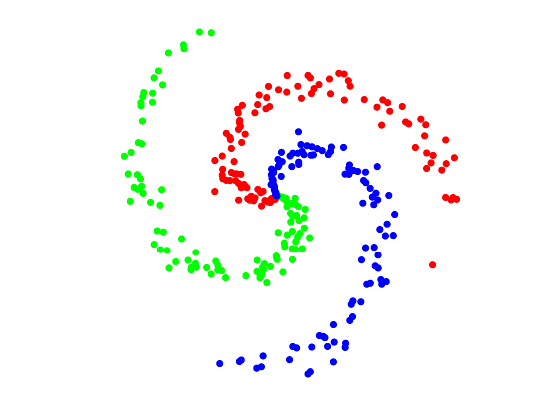

In [4]:
col = {'r' 'g' 'b'};
clf;  hold on;
for j=1:k
    I = find(y==j);
    plot(x(1,I), x(2,I), '.', 'color', col{j}, 'MarkerSize', 20);
end
axis equal; axis off;

Class probability matrix.

In [5]:
Y = double( repmat((1:k)', [1,n]) == repmat(y, [k,1]) );

Building the Network
--------------------
We setup the network. It is parameterized by the dimensions of the layers.


The network is composed of $R$ layers, and operate by initialyzing $x_0=x$ and then iterating
$$ \forall r=0,\ldots,R, \quad x_{r+1} \eqdef \rho(A_r x_r + b_r).  $$
Here $\rho : \RR \mapsto \RR$ is a non-linear activation function which
operate coordinate by coordinate. The intermediate variables are $x_r \in \RR^{d_r}$
with $(d_0,d_{L+1})=(p,k)$. The matrices have size $A_r \in \RR^{d_{r+1} \times d_r}$
while the biases have size $b_r \in \RR^{d_{r+1}}$.


The final value is obtained by comparing the predicted value $x_{R+1}$
to the data $y$ using some loss function
$$ \ell \eqdef \Ll(x_{R+1},y). $$


Load the loss and its gradient.
Here we use a multi-class logistic loss
$$ \Ll(z,y) \eqdef \log \sum_{i=1}^k e^{z_i} - \dotp{z}{y}.  $$


Note that in practice the computation is done in parallel over an array
$x$ of size $(p,n)$ of $n$ points in $\RR^p$, where the class
probability to predict is an array $y$ of size $k,n$ where $k$ is
the number of classes.

In [6]:
dotp = @(x,y)sum(x(:).*y(:));
max2 = @(S)repmat(max(S,[],2), [1 size(S,2)]);

stabilized log-sum-exp

In [7]:
LSE = @(S)log( sum(exp(S), 2) );
LSE = @(S)LSE( S-max2(S) ) + max(S,[],2);

stabilized soft-max

In [8]:
SM = @(S)exp(S) ./ repmat( sum(exp(S),2), [1 size(S,2)]);
SM = @(S)SM(S-max2(S));

energy, y being a target probability distribution

In [9]:
loss.F = @(z,y)sum(LSE(z')) - dotp(z,y);

gradient

In [10]:
loss.G = @(z,y)SM(z')' -  y;

Load the activation function. Here we use an atan sigmoid function.

In [11]:
rho.F  = @(u)atan(u);
rho.G = @(u)1./(1+u.^2);

Display the activation.

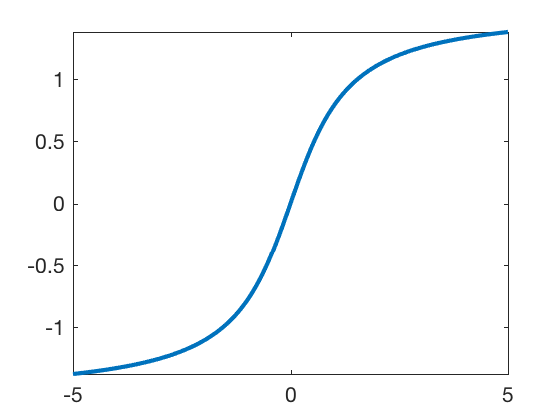

In [12]:
t = linspace(-5,5,201);
clf;
plot(t, rho.F(t), 'LineWidth', 2);
axis tight;

Dimensions $d_r$ of the layers.

In [13]:
D = [p 15 k]; % here a single hidden layer

Initialize the layers randomly.

In [14]:
R = length(D)-1; 
A = {}; b = {}; 
for r=1:R
    A{r} = randn(D(r+1),D(r));
    b{r} = randn(D(r+1),1);
end

Evaluate the network.
Bookkeep the intermediate results: this is crucial for the computation of
the gradient.

In [15]:
X = {};
X{1} = x;
for r=1:R
    X{r+1} = rho.F( A{r}*X{r}+repmat(b{r},[1 n]) );
end
L = loss.F(X{R+1},Y);

Network Optimization
--------------------
The network parameters are optimized by minimizing the non-convex
empirical loss minimization through gradient descent.


Initialize the gradient as
$$ \nabla_{x_{R+1}} \ell = \nabla \Ll(x_{R+1},y) $$

In [16]:
gx = loss.G(X{R+1},Y);

The successive gradient with respect to the intermediate variables $x_r$
are solutions of a backward recursion, which
corresponds to the celebrated backpropagation algorithm.
$$ \forall r=R,\ldots,1, \quad
      \nabla_{x_{r}} \ell = A_r^\top M_r $$
where we denoted
$$ M_r \eqdef \rho'(A_r x_r + b_r ) \odot \nabla_{x_{r+1}} \ell, $$
where $\odot$ is entry-wise multiplications.


From these gradients with respect to the intermediate layers variables, the
gradient with respect to the network  paramters are retrieved as
$$ \nabla_{A_r} \ell = M_r x_r^\top, \qandq
    \nabla_{b_r} \ell = M_r 1_n.  $$


Perform the back-propagation.

In [17]:
gA = {}; gb = {};
for r=R:-1:1
    M = rho.G(A{r}*X{r}+repmat(b{r},[1 n])) .* gx;
    % nabla_X{r} 
    gx = A{r}' * M;
    % nabla_A{r}
    gA{r} =  M * X{r}';
    % nabla_b{r}
    gb{r} =  sum(M,2);
end

__Exercise 1__

Implement the gradient descent.

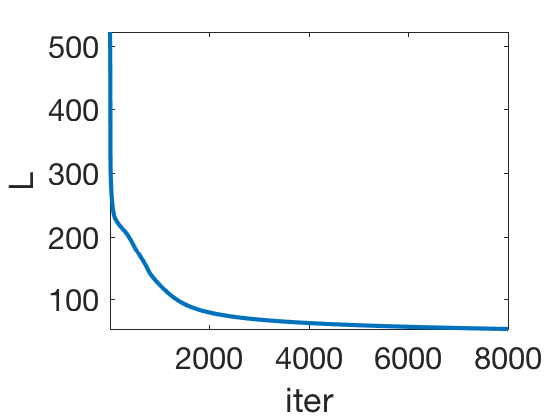

In [18]:
exo1()

In [19]:
%% Insert your code here.

Grid for evaluation.

In [20]:
q = 100;
t = linspace(-1,1,q);
[Yg,Xg] = meshgrid(t,t);
Z = [Xg(:)';Yg(:)'];

Classification maps

In [21]:
V = EvalNN(Z,[], A,b,loss,rho); 
U = reshape(SM(V{end}'), [q q k]);

Turn it into color.

In [22]:
col = [ [1 0 0]; [0 1 0]; [0 0 1]; [0 0 0]; [0 1 1]; [1 0 1]; [1 1 0]; ...
    [1 .5 .5]; [.5 1 .5]; [.5 .5 1]  ]';
R = zeros(q,q,3);
for i=1:k
    for a=1:3
        R(:,:,a) = R(:,:,a) + U(:,:,i) .* col(a,i);
    end
end

Final display of points and class probability.

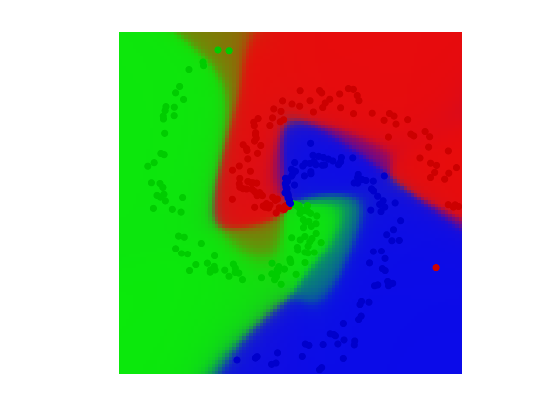

In [23]:
clf;  hold on;
imagesc(t,t,permute(R, [2 1 3]));
for j=1:k
    I = find(y==j);
    plot(x(1,I), x(2,I), '.', 'color', col(:,j)*.8, 'MarkerSize', 20);
end
axis equal; axis off;

__Exercise 2__

Check the influence of the number of layers

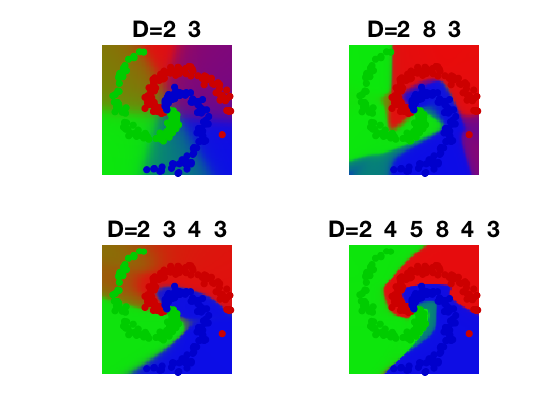

In [24]:
exo2()

In [25]:
%% Insert your code here.